In [18]:
%matplotlib notebook

from math import sqrt

import pandas as pd
import matplotlib.pyplot as plt
import pvlib

In [19]:
lat, lon = 40.4, -3.7
tilt = lat - 10

diffuse_model = 'haydavies'

In [20]:
data_pvgis = pvlib.iotools.get_pvgis_tmy(lat, lon)

alt = data_pvgis[2]['location']['elevation']

data_tmy = data_pvgis[0].rename(columns={
    'Gb(n)': 'dni',
    'G(h)': 'ghi',
    'Gd(h)': 'dhi',
    'T2m': 'temp_air',
    'WS10m': 'wind_speed',
})

data = data_tmy.set_index(
    data_tmy.index.map(lambda t: t.replace(year=2010)))

location = pvlib.location.Location(
    latitude=lat, longitude=lon, altitude=alt, tz='utc')

solpos = location.get_solarposition(data.index)

In [21]:
A_ref = 10

# Canadian Solar CS1U-410MS - PVSyst
A = 2.061  # m2

corr = A_ref / A
A *= corr

pv_mod_params = {
    "alpha_sc": 4.8e-3,  # coef. temp. Isc
    "gamma_ref": 0.967,  # "Datos básicos"
    "mu_gamma": -0.00042,  # "Parámetros modelo" [1/K]
    "I_L_ref": 9.7 *sqrt(corr), # Isc
    "I_o_ref": 0.03e-9,  # "Datos básicos"
    "R_sh_ref": 600,  # R paral ref "Parámetros modelo"
    "R_sh_0": 2500,  # R paral G=0 W/m2 "Parámetros modelo"
    "R_s": 0.291,  # R serie "Parámetros modelo"
    "cells_in_series": 81 *sqrt(corr),
}

In [22]:
# calcula Pmp STC
Pdc_stc = pvlib.pvsystem.singlediode(*pvlib.pvsystem.PVSystem(
    module_parameters=pv_mod_params
    ).calcparams_pvsyst(
    effective_irradiance=1000,
    temp_cell=25))['p_mp']

eff_a = Pdc_stc / (1000 * A)

print(f'Pdc_stc={Pdc_stc:.0f} eff_a={eff_a:.2%}')

Pdc_stc=2050 eff_a=20.50%


In [23]:
temp_mod_params = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['pvsyst']['freestanding']
print(temp_mod_params)

{'u_c': 29.0, 'u_v': 0}


## Modelo pérdidas angulares
> pvlib.iam.martin_ruiz
> https://pvlib-python.readthedocs.io/en/stable/generated/pvlib.iam.martin_ruiz.html

>* a_r (numeric) – The angular losses coefficient described in equation 3 of [1]. This is an empirical dimensionless parameter. Values of a_r are generally on the order of 0.08 to 0.25 for flat-plate PV modules.

> $IAM = \frac{1 - \exp(-\cos(\frac{aoi}{a_r}))} {1 - \exp(\frac{-1}{a_r}}$

<IPython.core.display.Javascript object>


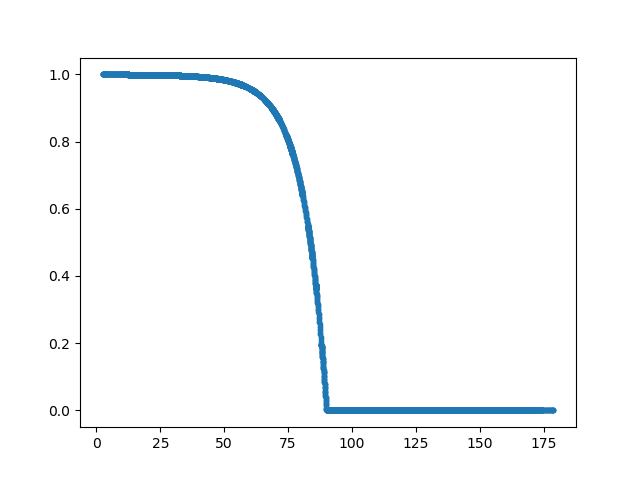

In [24]:
#%% Modelo PVSyst
pv_sys = pvlib.pvsystem.PVSystem(
    surface_tilt=tilt,
    surface_azimuth=180,
    module_parameters=pv_mod_params,
    temperature_model_parameters=temp_mod_params,
    modules_per_string=1,
)

pv_irr = pv_sys.get_irradiance(
    solar_zenith=solpos['zenith'],
    solar_azimuth=solpos['azimuth'],
    ghi=data['ghi'],
    dhi=data['dhi'],
    dni=data['dni'],
    dni_extra=pvlib.irradiance.get_extra_radiation(data.index),
    model=diffuse_model
)

aoi = pv_sys.get_aoi(
    solar_zenith=solpos['zenith'],
    solar_azimuth=solpos['azimuth'],
)

plt.plot(aoi, pvlib.iam.martin_ruiz(aoi, a_r=0.16), '.')

# Modelo pérdidas angulares
irradiance = pv_irr['poa_global']
effective_irradiance = irradiance * pvlib.iam.martin_ruiz(aoi, a_r=0.16)

## Modelo térmico
> pvlib.temperature.pvsyst_cell
>https://pvlib-python.readthedocs.io/en/stable/generated/pvlib.temperature.pvsyst_cell.html

>* u_c (float, default 29.0) – Combined heat loss factor coefficient. The default value is representative of freestanding modules with the rear surfaces exposed to open air (e.g., rack mounted). Parameter Uc in (1) [W/(m^2 C)].
>* u_v (float, default 0.0) – Combined heat loss factor influenced by wind. Parameter Uv in (1) [(W/m^2 C)(m/s)].
>* eta_m (numeric, default 0.1) – Module external efficiency as a fraction, i.e., DC power / poa_global. Parameter ηm in (1).
>* alpha_absorption : numeric, default 0.9

>The Pvsyst model for cell temperature $T_{C}$ is given by

>$T_{C} = T_{a} + \frac{\alpha E (1 - \eta_{m})}{U_{c} + U_{v} \times WS}$

Toma los valores por defecto para una configuración 'freestanding'. También acepta 'insulated', además de los valores numéricos directamente


In [25]:
cell_temp = pv_sys.pvsyst_celltemp(
    poa_global=effective_irradiance,
    temp_air=data['temp_air'],
    wind_speed=data['wind_speed']
)

## Modelo PVSyst 5 parametros modelo diodo
> pvlib.pvsystem.calcparams_pvsyst
https://pvlib-python.readthedocs.io/en/stable/generated/pvlib.pvsystem.calcparams_pvsyst.html


In [26]:
diode_parameters = pv_sys.calcparams_pvsyst(
    effective_irradiance=effective_irradiance,
    temp_cell=cell_temp,
)

power = pv_sys.singlediode(*diode_parameters)

Yr = irradiance.resample('M').sum() / 1000
Ya = power['p_mp'].resample('M').sum() / Pdc_stc
Lc = Yr - Ya

PR = Ya / Yr

<IPython.core.display.Javascript object>


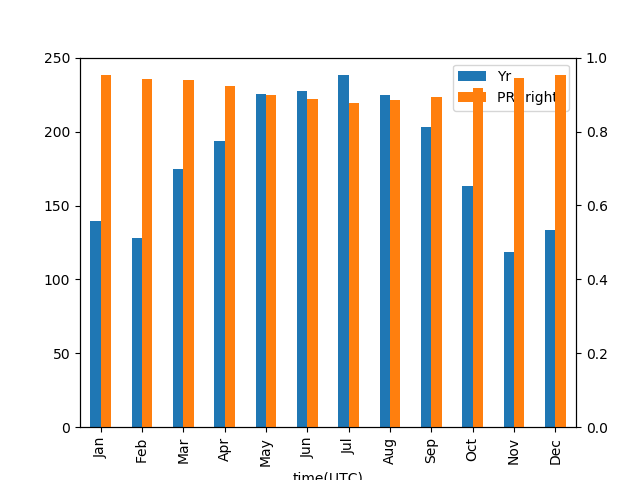

PR=0.91, Ya=1982 kWh/kW, Yr=2171 kWh/kW
Total annual energy per reference area=4062 kWh/year


In [27]:
data_monthly = pd.concat([Yr, PR], axis='columns')
data_monthly.columns = ['Yr', 'PR']

ax = data_monthly.plot(kind='bar', secondary_y='PR')
ax.set_xticklabels(data.resample('M').sum().index.strftime('%b'))

print(f'PR={Ya.sum()/Yr.sum():.2}, Ya={Ya.sum():.0f} kWh/kW, Yr={Yr.sum():.0f} kWh/kW')
print(f'Total annual energy per reference area={power["p_mp"].sum()/1000:.0f} kWh/year')